# Forecasting Euribor with ARIMA

In this notebook Euribor rates are predicted with ARIMA model using statsmodels library. 

## Loading the data

In [110]:
import pandas as pd
import numpy as np
# load dataset
df = pd.read_csv('historical_euribor.csv', header=0, index_col=0)
# we don't need this column and just makes things harder
df = df.drop(['period'], axis=1)
# set date as index and convert the field to datetime
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
#df.index = df.index.to_period('M')
print(df)

            1mo euribor  3mo euribor  6mo euribor  12mo euribor
date                                                           
1994-01-01       7.1200       6.9100       6.6700        6.3400
1994-02-01       6.9900       6.8600       6.6800        6.4200
1994-03-01       6.8400       6.7500       6.6500        6.5500
1994-04-01       6.6900       6.5700       6.5100        6.4600
1994-05-01       6.3200       6.2400       6.2100        6.2500
...                 ...          ...          ...           ...
2023-05-01       3.1474       3.3664       3.6790        3.8618
2023-06-01       3.3425       3.5359       3.8253        4.0073
2023-07-01       3.4690       3.6718       3.9425        4.1490
2023-08-01       3.6270       3.7803       3.9445        4.0730
2023-09-01       3.7577       3.8800       4.0303        4.1492

[357 rows x 4 columns]


## Parameter selection
ARIMA has three parameters (p,d,q):
-  p = is the order of the model
-  d = the degree of differentiation
-  q = order of the moving-average model.

Let's do some statistical testing and plotting to esimate good parameters for our model.

### Trends and patterns
From plots below we can see quite obvious downward and seasonal trends so our data is not stationary and Augmented Dickey-Fuller (ADF) test confirms this. Euribor rates follow each other quite closely but shorter rates peak a little later than longer euribors. This suggest we should use differentiation. Plotting the differentiated data of 1st order and performing ADF again confirms that first order of differentation is sufficient to make the data stationary. Thus d=1 is sufficient. 

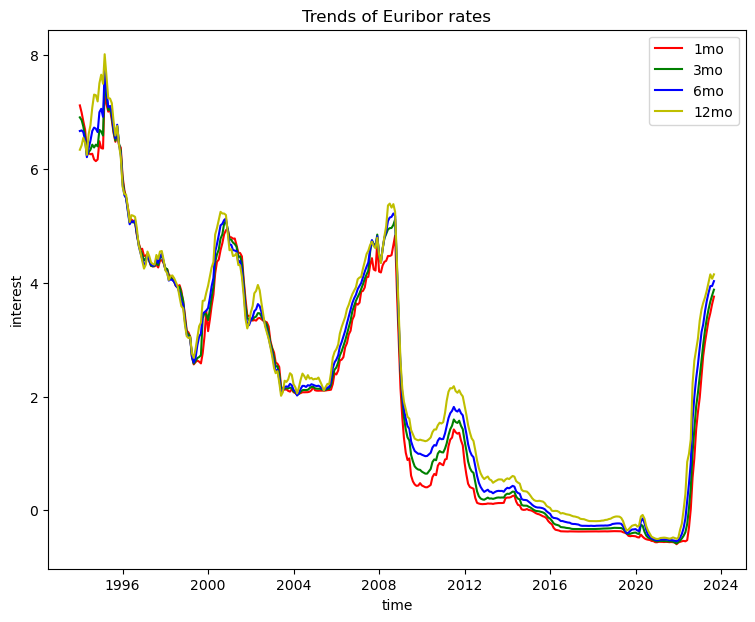

In [111]:
from matplotlib import pyplot as plt
# let's study our data for trends and patterns first
plt.plot(df['1mo euribor'], color='r', label='1mo') 
plt.plot(df['3mo euribor'], color='g', label='3mo') 
plt.plot(df['6mo euribor'], color='b', label='6mo') 
plt.plot(df['12mo euribor'], color='y', label='12mo') 

# Naming the x-axis, y-axis and the whole graph 
plt.xlabel("time") 
plt.ylabel("interest") 
plt.title("Trends of Euribor rates") 
  
# Adding legend, which helps us recognize the curve according to it's color 
plt.legend() 
  
# To load the display window 
plt.show() 

ADF test for undifferentiated data gives p-value of 0,189877 which is not significant at 95% confidence level and thus indicates that data is non-stationary. 

In [112]:
# Augmented Dickey-Fuller test cofirms our data is not stationary
# It's sufficient to study single euribor since the rates follows each other so closely. 

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['3mo euribor'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.246287
p-value: 0.189877
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


After first order differentation the p-value is 0,000753 indicating significance so the data is now stationary. Plotting the original and differentiated data confirms this. Thus q = 1.

ADF Statistic: -4.165761
p-value: 0.000753
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


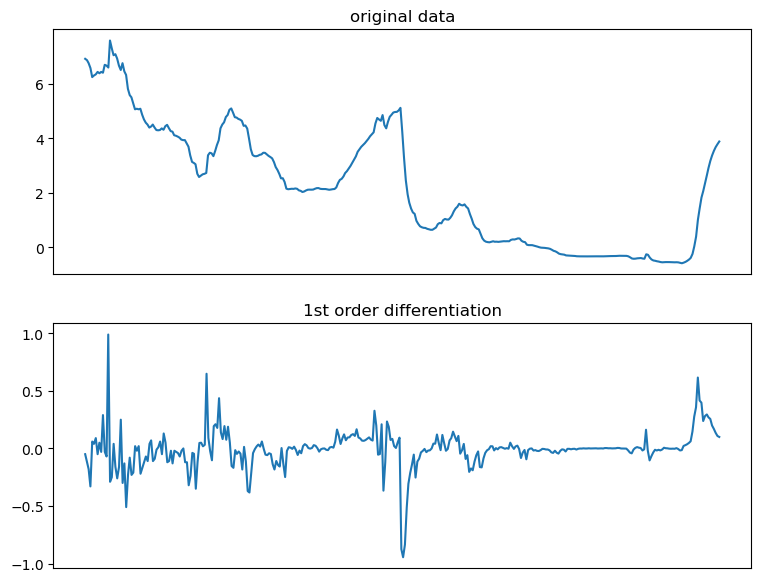

In [113]:
# Next try to find at which order of differentation we can make the data stationary

df['diff_3mo'] = df['3mo euribor'].diff()
#df.dropna(inplace=True)

result = adfuller(df['diff_3mo'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

# First order is enough (p-value is now significant)

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':100})
 
# Original Series
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df['3mo euribor']); 
ax1.set_title('original data')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df['3mo euribor'].diff())
ax2.set_title('1st order differentiation')
ax2.axes.xaxis.set_visible(False)

plt.show()


### Autocorrelation 

Autocorrelation plot suggests strong autocorrelation since the plot is out of the 5% significance limits for most of the lags. Looking more closely partial auto-correlation plots we see that the first two lags are significantly above the limits so let's choose p=2. With same logic we can select q=2.

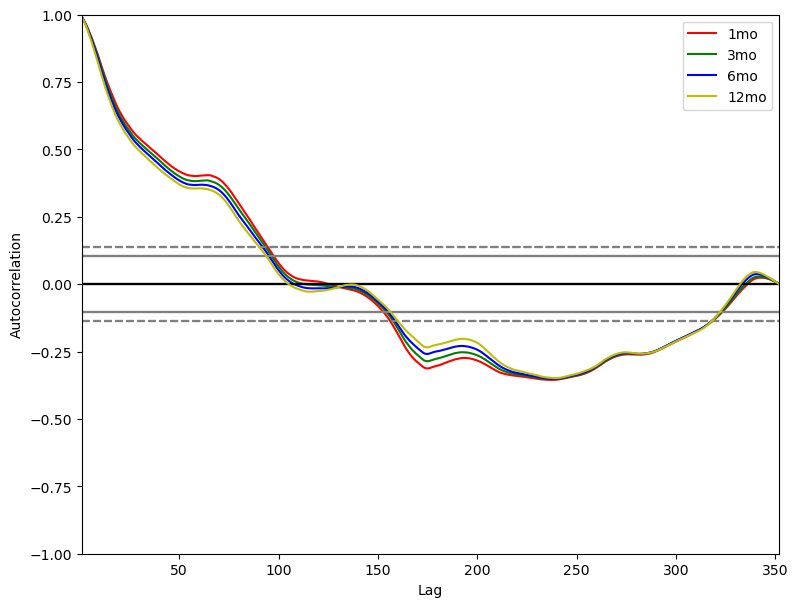

In [93]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['1mo euribor'], color='r', label='1mo')
autocorrelation_plot(df['3mo euribor'], color='g', label='3mo')
autocorrelation_plot(df['6mo euribor'], color='b', label='6mo') 
autocorrelation_plot(df['12mo euribor'], color='y', label='12mo') 

plt.show()

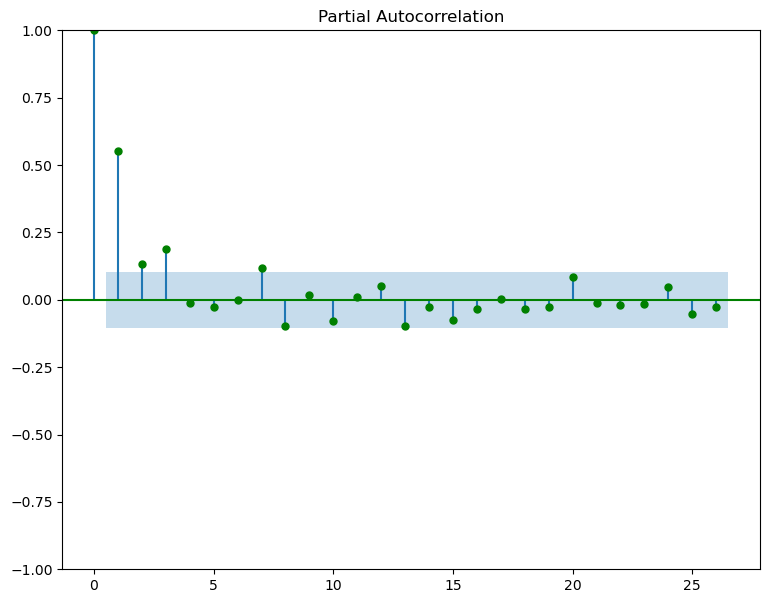

In [95]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['diff_3mo'].dropna(), color='g')

plt.show()

q parameter can be found with the help of autocorrelaction function. Again the first two lags seems to be most significant so select q=2.

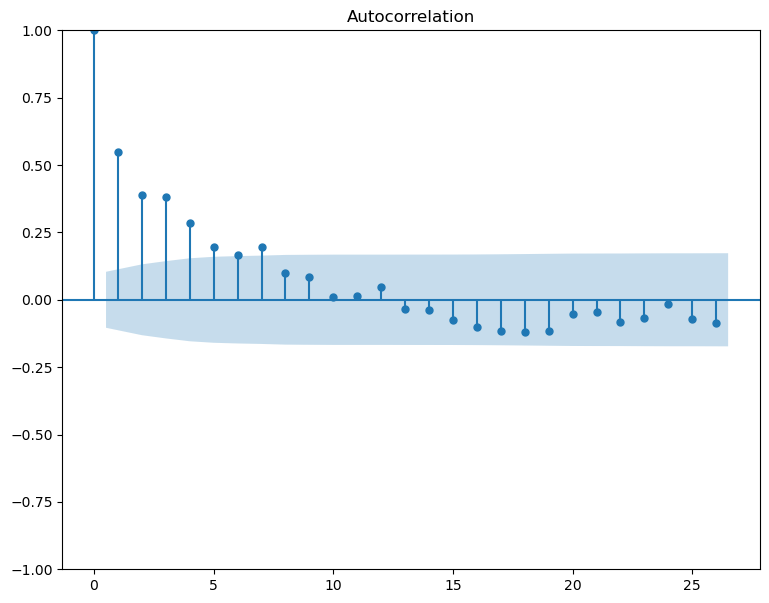

In [114]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['diff_3mo'].dropna())
plt.show()


## Conclusions in parameter selection
By using plotting and statistical hypothesis testing we may conclude that ARIMA(2,1,2) should be a good fit for our model. 

# ARIMA fitting

Now that we have the model we can finally fit our data. 

In [119]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [126]:
# helper that does the actual ARIMA forecasting
def forecast(predictions, history, test_data):
    for t in range(len(test_data)):
        model = ARIMA(history, order=(2,1,2))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))

1mo euribor
MSE: 0.004363352522528925
MAE: 0.027885425507479366
RMSE: 0.06605567744356972
Last observed value: [3.627  3.7577], last predicted value: [3.5685164078797764, 3.7313000557013045]


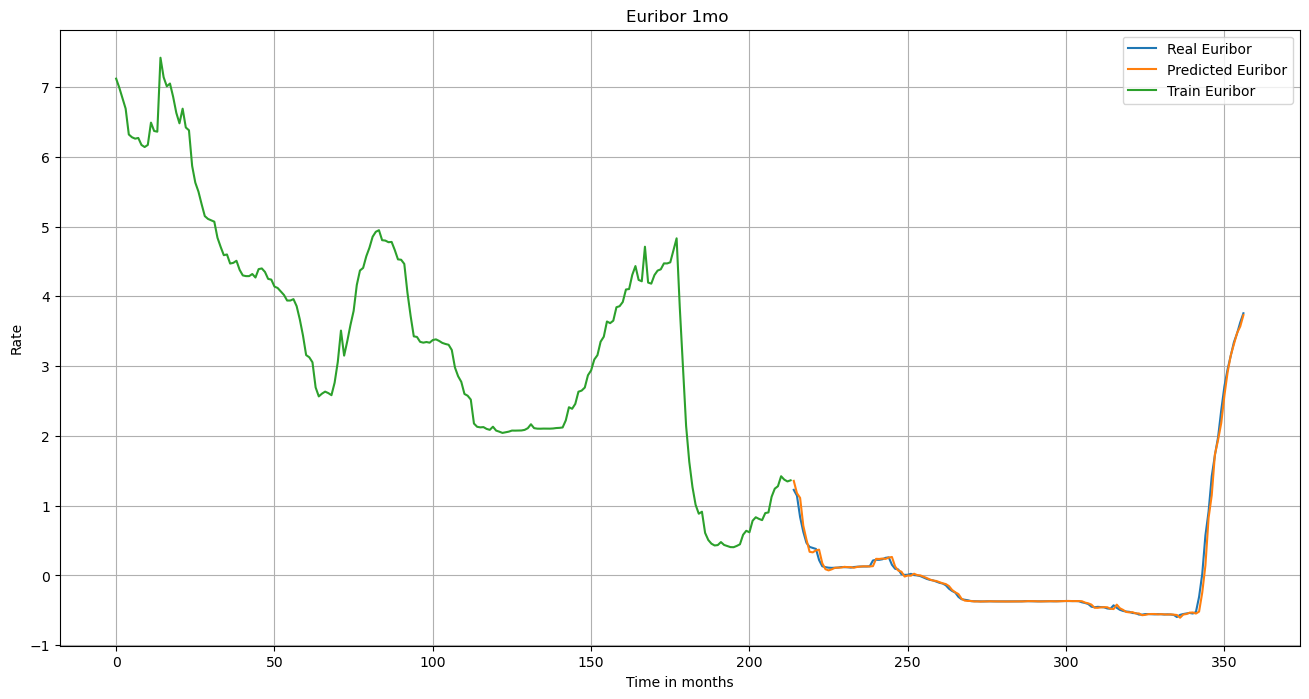

3mo euribor
MSE: 0.00364921773485032
MAE: 0.02812913989171367
RMSE: 0.06040875544861291
Last observed value: [3.7803 3.88  ], last predicted value: [3.7735860247745574, 3.8624253962936717]


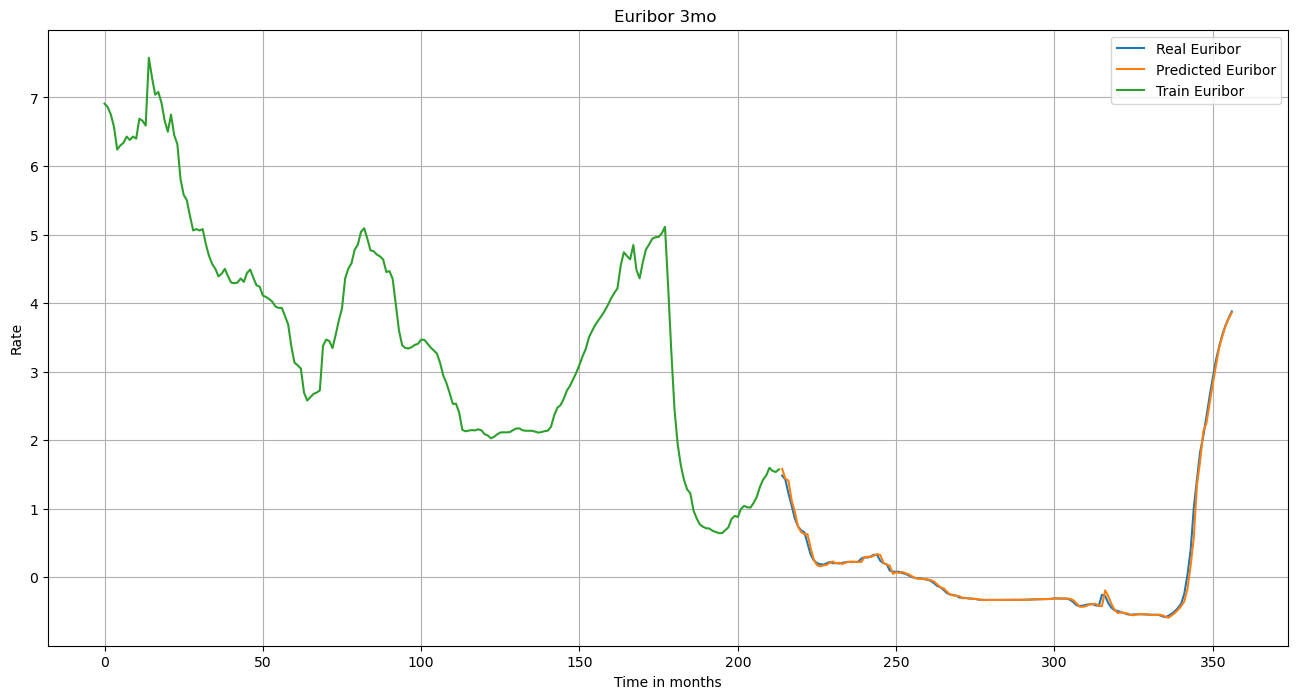

/home/tintti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tintti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6mo euribor
MSE: 0.004539468779636789
MAE: 0.0326410854226907
RMSE: 0.06737557999480813
Last observed value: [3.9445 4.0303], last predicted value: [4.030258060564531, 3.9635492146732503]


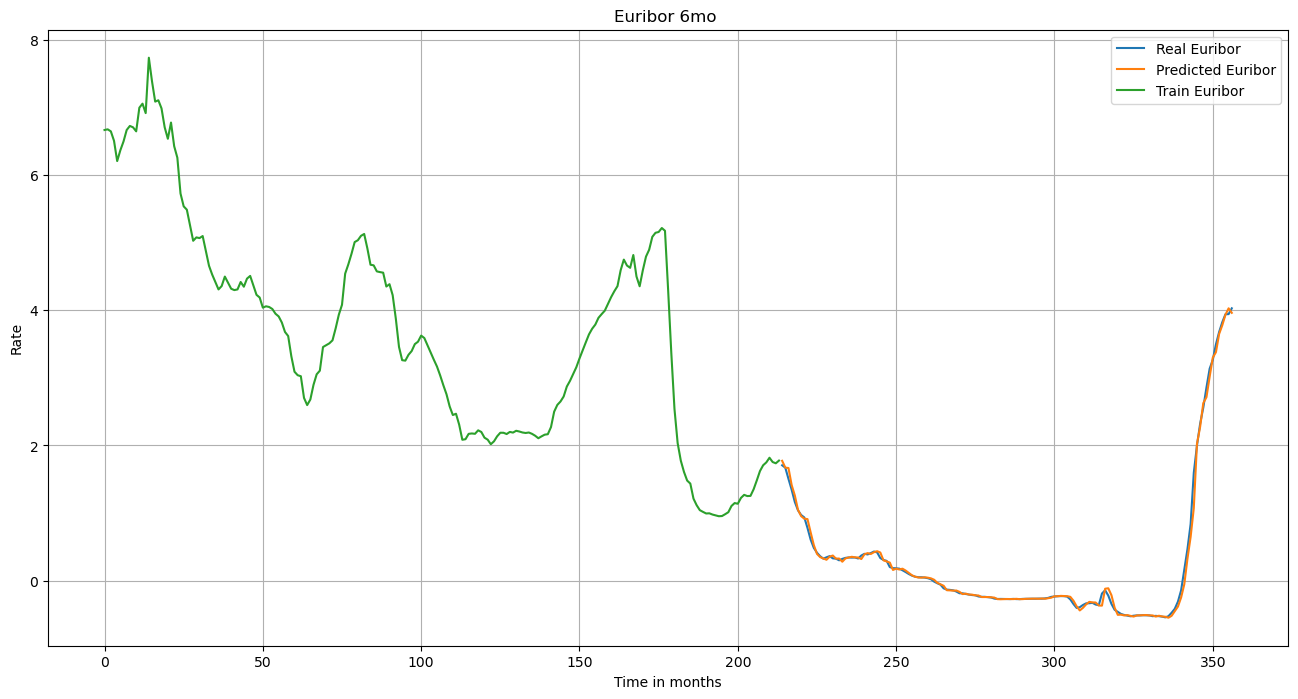

/home/tintti/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12mo euribor
MSE: 0.008456653010595715
MAE: 0.04093025381419049
RMSE: 0.09196006204106061
Last observed value: [4.073  4.1492], last predicted value: [4.238061946668482, 4.060349345181041]


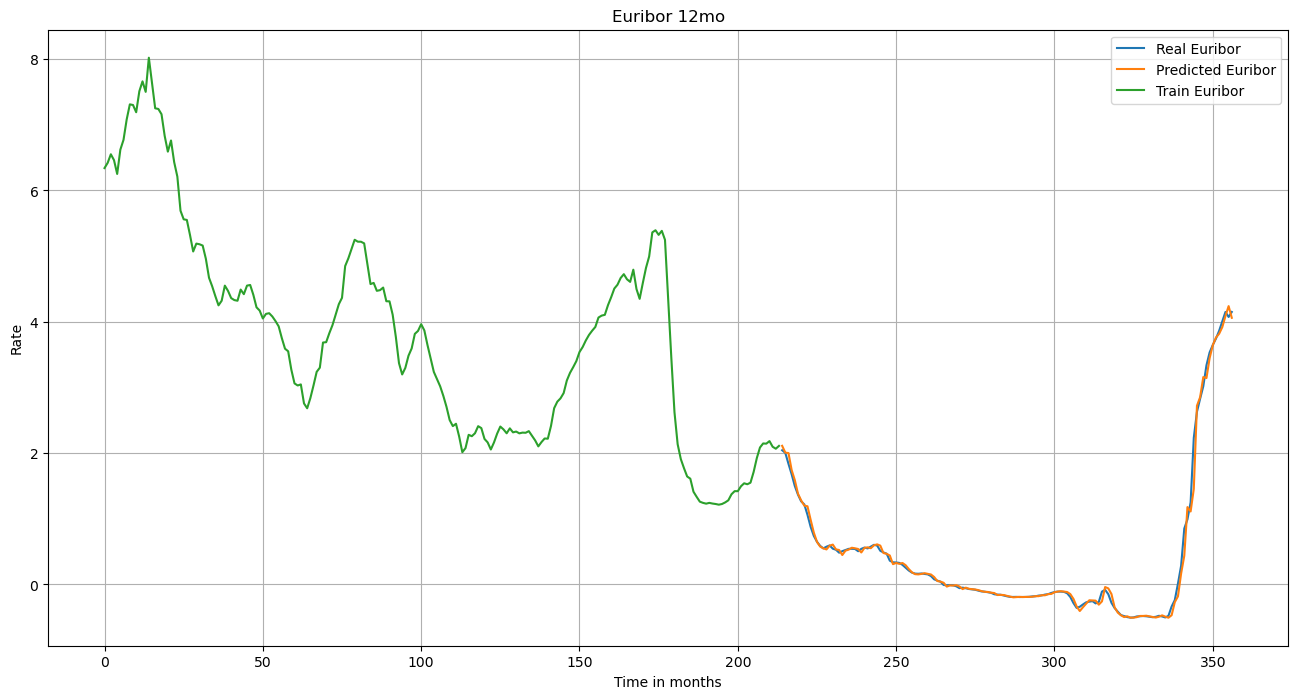

diff_3mo
MSE: 0.0031428109302739497
MAE: 0.02892348795305625
RMSE: 0.0560607788946421
Last observed value: [0.1085 0.0997], last predicted value: [0.1753486812632352, 0.14562604901125586]


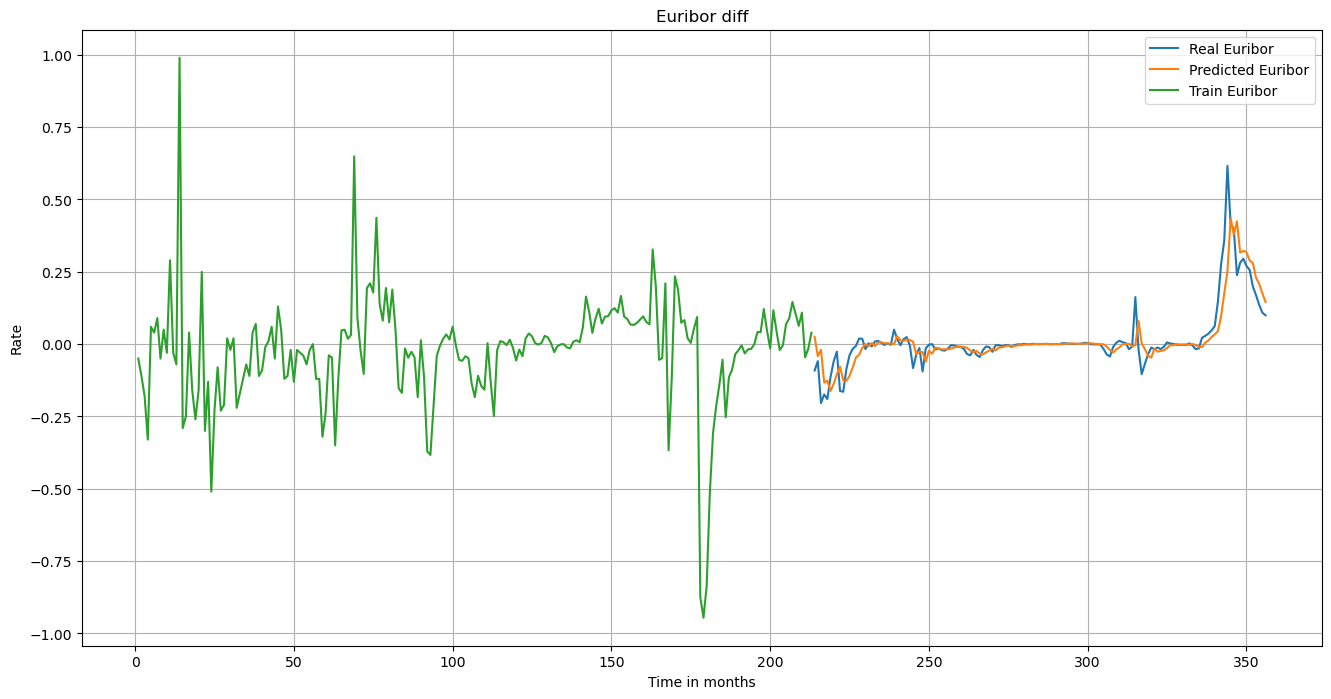

In [137]:
# fit the model
# loop through 1/3/6/12 mo interest rates in data frame 

# split into train and test sets
for (colName, colData) in df.items():
    X = colData.values
    size = int(len(X) * 0.6)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    # rolling forecast
    forecast(predictions, history, test)

    print(colName)
    # evaluate performance
    mse = mean_squared_error(test, predictions)
    print(f"MSE: {mse}")
    mae = mean_absolute_error(test, predictions)
    print(f"MAE: {mae}")
    rmse = math.sqrt(mean_squared_error(test, predictions))
    print(f"RMSE: {rmse}")
    print(f"Last observed values: {test[-3:]}, last predicted values: {predictions[-3:]}")

    # plot forecasts against actual outcomes

    plt.figure(figsize=(16,8))
    plt.plot(np.arange(len(predictions)) + len(train), test)
    plt.plot(np.arange(len(predictions)) + len(train), predictions)
    plt.plot(train)


    plt.legend(['Real Euribor', 'Predicted Euribor','Train Euribor'])
    plt.title(f"Euribor {colName[:4]}")
    plt.xlabel('Time in months')
    plt.ylabel('Rate')
    plt.grid(True)
    plt.savefig(f"arima_model_{colName[:4]}.pdf")
    plt.show()